# F4 Pre Trained Autoencoders

From:

- https://github.com/CompVis/latent-diffusion#pretrained-autoencoding-models


### KL Autoencoder

In [1]:
import os
import wget
import zipfile

def download_pre_trained_ae(url, output_dir):
    if os.path.exists(output_dir):
        print("Used cache")
    else:
        filename = wget.download(url)

        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall(output_dir)

        if os.path.exists(filename):
            os.remove(filename)

In [2]:
download_pre_trained_ae("https://ommer-lab.com/files/latent-diffusion/kl-f4.zip", './klf4')

Used cache


In [3]:
def load_model(config, ckpt, gpu, eval_mode):
    if ckpt:
        print(f"Loading model from {ckpt}")
        pl_sd = torch.load(ckpt, map_location="cpu")
        global_step = pl_sd["global_step"]
    else:
        pl_sd = {"state_dict": None}
        global_step = None
    model = load_model_from_config(config.model,
                                   pl_sd["state_dict"])

    return model, global_step

In [4]:
import torch
from ldm.models.autoencoder import AutoencoderKL

ddconfig = {
    "double_z": True,
    "z_channels": 3,
    "resolution": 256,
    "in_channels": 3,
    "out_ch": 3,
    "ch": 128,
    "ch_mult": [1,2,4],
    "num_res_blocks": 2,
    "attn_resolutions": [],
    "dropout": 0.0
}
lossconfig = {
      "target": "ldm.modules.losses.LPIPSWithDiscriminator",
      "params": {
        "disc_start": 50001,
        "kl_weight": 1.0e-06,
        "disc_weight": 0.5
      }
}
embed_dim = 3

pl_sd = torch.load("klf4/model.ckpt", map_location="cpu")

model = AutoencoderKL(ddconfig, lossconfig, embed_dim)

model.load_state_dict(pl_sd["state_dict"] ,strict=False)
model.cuda()
model.eval()

making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth


AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (1): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
  

In [5]:
import numpy as np

imarray = np.random.rand(1, 3, 128, 128) * 255

input = torch.FloatTensor(imarray).cuda()

output = model.encoder(input)

print(output.max())
print(output.min())
# print(min(output), max(output))
# output.shape

# model()

tensor(14.1557, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-13.6006, device='cuda:0', grad_fn=<MinBackward1>)


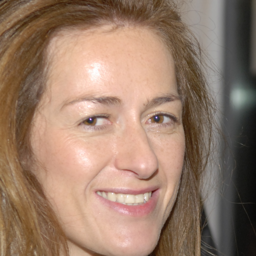

In [6]:
from PIL import Image
image1 = Image.open("/data/ffhq/images256x256/40058_256.png")
image1.show()

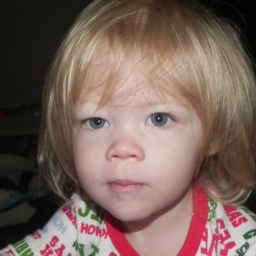

In [7]:
image2 = Image.open("/data/ffhq/images256x256/28154_256.png")
image2.show()

In [8]:
def custom_to_pil(x):
    x = x.detach().cpu()
    x = torch.clamp(x, -1., 1.)
    x = (x + 1.) / 2.
    x = x.permute(1, 2, 0).numpy()
    x = (255 * x).astype(np.uint8)
    x = Image.fromarray(x)
    if not x.mode == "RGB":
        x = x.convert("RGB")
    return x

def logs2pil(logs, keys=["sample"]):
    imgs = []
    for k in logs:
        print("=" * 77)
        try:
            if len(logs[k].shape) == 4:
                img = custom_to_pil(logs[k][0, ...])
            elif len(logs[k].shape) == 3:
                img = custom_to_pil(logs[k])
            else:
                print(f"Unknown format for key {k}. ")
                img = None
        except:
            img = None
        imgs.append(img)
    return imgs

In [19]:
from einops import rearrange

imarray = np.array([np.array(image2)])

grid = rearrange(imarray, 'b h w c -> b c h w')

In [20]:
import numpy as np

# imarray = np.array([np.array(image1), np.array(image2)])

# newarr = imarray.reshape(2, 3, 256, 256)

# newarr = np.reshape(np.array(image1), np.array(image1).shape + (1,)).reshape(1, 3, 256, 256)

# newarr = np.array(image1)[:, :, np.newaxis]

input = torch.FloatTensor(grid).cuda()

# output = model.encoder(input)

# output = model(input)[0].cpu().detach().numpy()
output = model(input)

# print(output.max())
# print(output.min())

# output = output.reshape(1, 256, 256, 3)[0]

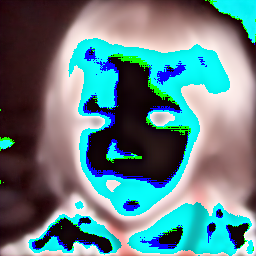

In [21]:
grid = np.array(rearrange(output[0].cpu().detach().numpy(), 'b c h w -> b h w c'))

grid[0, ...].shape

im = Image.fromarray(np.uint8(grid[0, ...] * 255))
im.show()

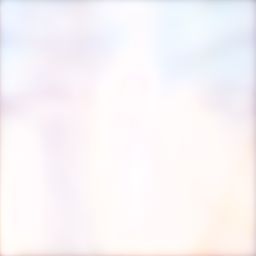

In [ ]:

x = output[0][0]

if len(x.shape) == 4:
    img = custom_to_pil(x[0, ...])
elif len(x.shape) == 3:
    img = custom_to_pil(x)
else:
    img = None

# ims = custom_to_pil(output[0][0, ...])
img